## Imports and Setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
import pandas as pd
import numpy as np
import nltk.tokenize
import itertools
import datetime
import torch

from sklearn.model_selection import train_test_split

from pathlib import Path

from fastai import *
from fastai.text import *

from copy import copy, deepcopy
from enum import Enum

from src.data_collection.multimodal_data import *
from src.nlp.neural_model import MultiModalRNN

### Model definitions
Define this notebooks "initializer model" (pretrained parameters and itos mapping) and the output model as well.

In [4]:
model_name = '4.2-MM-108k-pre'
MODEL_PATH = Path(f'../data/models/{model_name}')
MODEL_PATH.mkdir(exist_ok=True)

init_model_name = '4.1-LM-108k-lines'
INIT_MODEL_PATH = Path(f'../data/models/{init_model_name}')
INIT_MODEL_PATH.mkdir(exist_ok=True)

### Tokenization
To create the model's tokens with the correct train-test split, run the code below. Only needed once on the notebook's first ever run.

In [5]:
MODEL_FIRST_RUN = False

In [6]:
def process_audio(model_path):
    '''
    500k link: https://storage.googleapis.com/capstone-deep-lyrics/lyrics-500k.csv
    108k link: https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv
    '''
    model_path = Path(model_path)
    model_path.mkdir(exist_ok=True)
    
    small_corpus_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv'
    audio_url = 'https://storage.googleapis.com/w210-capstone/data/msd-aggregate.csv'
    tag_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics_tags.csv'
    
    df = pd.read_csv(small_corpus_url,
                 header=None, escapechar='\\',
                 names=['msd_id', 'lyrics'])
    
    # only keep lyrics with length < 5000
    df = df[df.lyrics.str.len() < 5000]
    
    # bring in audio features
    df_audio = pd.read_csv(audio_url)
    df_audio.rename(columns={'track_id': 'msd_id'}, inplace=True)
    
    # bring in tags
    df_tags = pd.read_csv(tag_url, index_col=0)
    df_tags.drop(columns=['lyrics'], inplace=True)
    
    # match audio to keys from lyrics
    df_audio = pd.merge(df, df_audio, how='inner', on='msd_id')
    
    # mat
    df_all = pd.merge(df_audio, df_tags, how='inner', on='msd_id')
    
    
    # split data using same seed as lm_data_lyrics.py
    df_train, df_valid = train_test_split(df_all,
                                         test_size=0.2,
                                         random_state=2018)
    
    df_train.to_csv(model_path/'df_train.csv')
    df_valid.to_csv(model_path/'df_valid.csv')
    
    return df_train, df_valid

In [7]:
if MODEL_FIRST_RUN:
    df_train, df_valid = process_audio(MODEL_PATH)

## Load Data

Now that we've created the tokens, let's load them into a `DataBunch` to train our LM further or generate text with a pre-trained LM.

In [8]:
if MODEL_FIRST_RUN:
    data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                          bs=128,
                                          max_vocab=20000)

In [9]:
data_lm = TextLMDataBunch.from_id_files(INIT_MODEL_PATH/'tmp')
data_lm.path = MODEL_PATH

In [10]:
data_lm.train_ds.vocab_size

20002

In [11]:
train_text = copy(data_lm.train_ds)
valid_text = copy(data_lm.valid_ds)

#### Audio Data

In [12]:
if not MODEL_FIRST_RUN:
    df_train = pd.read_csv(MODEL_PATH/'df_train.csv', index_col=0)
    df_valid = pd.read_csv(MODEL_PATH/'df_valid.csv', index_col=0)

## Feature Engineering

SUPER HACKY IN THIS NOTEBOOK

In [14]:
# manual genre consolidating
genre_map = pd.read_excel('../data/external/genre_tag_mapping.xlsx', header=None,
                         names=['tag', 'mapped_tag'], usecols=[0,4], skiprows=1)
genre_map.loc[genre_map['mapped_tag'].isnull(), 'mapped_tag'] = genre_map['tag']
genre_map.iloc[40:45]

,tag,mapped_tag
40,funk,funk
41,thrash metal,metal
42,black metal,metal
43,ska,ska
44,House,electronic


In [15]:
# tag list based on combined genres
top_tags = pd.read_excel('../data/external/genre_tag_mapping.xlsx', header=None,
                         names=['tag', 'tag1', 'tag2', 'combined', 'mapped_tag'],
                         skiprows=1)
top_tags.loc[top_tags['mapped_tag'].isnull(), 'mapped_tag'] = top_tags['tag']
top_tags = top_tags.groupby('mapped_tag')\
    .sum().sort_values('combined', ascending=False)
tag_list = set(top_tags.head(20).index)

In [16]:
tag_list

{'80s',
 'Hip-Hop',
 'alternative',
 'blues',
 'christian',
 'classic rock',
 'country',
 'dance',
 'electronic',
 'female vocalists',
 'folk',
 'foreign',
 'indie',
 'jazz',
 'metal',
 'pop',
 'punk',
 'rock',
 'singer-songwriter',
 'soul'}

In [17]:
def combine_tag(X, tag_list):
    """
    Apply heuristic for genre tagging. Some genres take priority, even if
        it doesn't appear in tag1. e.g. 'christian' is highly distinguishable
    
    1. if all tags are missing set to 'missing'
    2. if any of the three tags are 'foreign' set to 'foreign'
    2. if any of the three tags are 'christian', set to 'christian'
    3. if any of the three tags are 'country', set to 'country'
    4. if any of the three tags are 'instrumental' set to 'instrumental'
    5. if any of the three tags are 'christmas' set to 'christmas'
    6. check membership in top tag list starting with tag1 as priority.
       top tags are constructed after consolidation
    7. All else is set to "other"
    
    """
    if pd.isnull([X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]).all():
        return 'missing'
    elif 'foreign' in [X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]:
        return 'foreign'
    elif 'christian' in [X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]:
        return 'christian'
    elif 'country' in [X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]:
        return 'country'
    elif 'instrumental' in [X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]:
        return 'instrumental'
    elif 'christmas' in [X.mapped_tag1, X.mapped_tag2, X.mapped_tag3]:
        return 'christmas'
    elif X.mapped_tag1 in tag_list:
        return X.mapped_tag1
    elif X.mapped_tag2 in tag_list:
        return X.mapped_tag2
    elif X.mapped_tag3 in tag_list:
        return X.mapped_tag3
    else:
        return 'other'

In [18]:
df_train2 = df_train.copy()
for i in range(1,4):
    df_train2 = pd.merge(df_train2, genre_map, how='left',
                   left_on=f'tag{i}', right_on='tag',
                   validate='m:1')
    df_train2.loc[df_train2.mapped_tag.isnull(), 'mapped_tag'] = df_train2[f'tag{i}']
    df_train2.drop(columns='tag', inplace=True)
    df_train2.rename(columns={'mapped_tag': f'mapped_tag{i}'}, inplace=True)
    
df_train2.head()

,msd_id,lyrics,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,...,song_id,title,track_7digitalid,year,tag1,tag2,tag3,mapped_tag1,mapped_tag2,mapped_tag3
0,TRALPFY12903CEB2F1,(Doo ronde ronde ronde pa pa\nDoo ronde ronde ...,22050,43d371a0485c605a82dce064150f6a9a,0.0,136.25424,0.485,0.0,7,0.045,...,SOQNDKC12AB018893B,I Met Him On A Sunday - Ronde-Ronde (Digitally...,9073328,0,NaN,NaN,NaN,NaN,NaN,NaN
1,TRIIEEK128F428F685,"Well, I pulled out of Pittsburgh\nI'm rollin' ...",22050,5aa26ebb3cd204a08c92ad884f956c6d,0.0,208.03873,0.000,0.0,9,0.690,...,SOATCCF12A8C141D7B,Six Days On The Road (Album Version),2433211,2008,rock,classic rock,classic rock,rock,classic rock,classic rock
2,TRBQILE128F14AA102,"[Chorus]\nDum, the dum-dum girl\nThe dum-dum g...",22050,5114c649abac35d94e88d8f0d1d93814,0.0,323.08200,0.363,0.0,0,0.502,...,SOYZNNP12A6D4F70D3,Dum Dum Girl (12'' Mix),650804,0,new wave,80s,80s,new wave,80s,80s
3,TRWRFVS128E0780CF2,You're the one who's always choking Trojan\nYo...,22050,833f5c7f194dc20179aa6f0783b7c69e,0.0,140.82567,0.276,0.0,10,0.822,...,SOWRRCE12A6310F10B,Commercial For Levi,3077,2000,alternative,alternative rock,alternative rock,alternative,alternative,alternative
4,TRBHZHS128F92CDE4C,"[Hook]\nCuanto me duele que, no estes aqui!\nT...",22050,7fd3ad867cb0ab0493ed95df5f4fdec3,0.0,194.87302,0.235,0.0,3,0.536,...,SOYWWWX12A8C13C64E,Tu No Sabes,4159689,2006,Reggaeton,don omar,don omar,Reggaeton,don omar,don omar


In [19]:
# processing
df_train2['tag'] = df_train2.apply(combine_tag, axis=1, tag_list=tag_list)

In [20]:
df_train2.loc[df_train2.tag == 'instrumental', :].sample(5)

,msd_id,lyrics,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,...,title,track_7digitalid,year,tag1,tag2,tag3,mapped_tag1,mapped_tag2,mapped_tag3,tag
78141,TRZMZCN128F426319A,Instrumental,22050,cd4adad6a0af321da1c4a86e36aad128,0.0,256.39138,0.247,0.0,5,0.448,...,Sing Sing Sing,919975,2001,funk,instrumental,instrumental,funk,instrumental,instrumental,instrumental
46787,TRZWFRK128F1462735,"Blue, blue, my world is blue\nBlue is my world...",22050,ad0f5bbf760a6922538b6d56094c53f3,0.0,153.73016,2.699,0.0,7,0.186,...,Love Is Blue,283789,1973,instrumental,easy listening,easy listening,instrumental,easy listening,easy listening,instrumental
8474,TRPZHLD128F92F9701,(Sometimes in Winter:)\n\nWhen I come home in ...,22050,c12afe1a67867379f009f2a602c65273,0.0,283.84608,2.357,0.0,1,0.147,...,Winter Melody,4915845,1997,instrumental,my gang 09,NaN,instrumental,my gang 09,NaN,instrumental
69988,TRRIHNX128F42752C7,Take me to the pretty place where once we used...,22050,42ef46ef559ad0768ebe770033a1244d,0.0,256.62649,0.078,0.0,11,0.195,...,Peace,994101,0,instrumental,Mellow,Mellow,instrumental,Mellow,Mellow,instrumental
65384,TRMJOKI128F932AC91,Instrumental,22050,be1340afd485983946ea962189635112,0.0,236.30322,0.200,0.0,2,0.160,...,Tramontane [Instrumental],5131552,0,pop,instrumental,instrumental,pop,instrumental,instrumental,instrumental


In [21]:
df_train2.loc[df_train2.tag == 'country', df_train2.columns[-7:]].sample(5)

,tag1,tag2,tag3,mapped_tag1,mapped_tag2,mapped_tag3,tag
29307,country,Alt-country,Alt-country,country,country,country,country
5725,country,John Denver,John Denver,country,John Denver,John Denver,country
7908,Alt-country,americana,americana,country,country,country,country
22111,chaser i,americana,americana,chaser i,country,country,country
13574,country,NaN,NaN,country,NaN,NaN,country


missing              0.278824
other                0.180965
rock                 0.094542
metal                0.069481
foreign              0.046943
electronic           0.034689
pop                  0.033917
punk                 0.029264
country              0.029172
soul                 0.027606
indie                0.026800
Hip-Hop              0.022089
jazz                 0.017033
alternative          0.014834
80s                  0.014753
folk                 0.012646
blues                0.012196
christian            0.010930
classic rock         0.010803
female vocalists     0.010665
dance                0.007094
singer-songwriter    0.006403
instrumental         0.005021
christmas            0.003328
Name: tag, dtype: float64


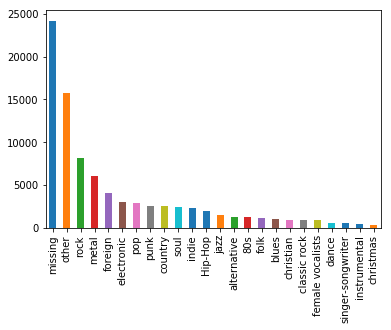

In [22]:
print(df_train2.tag.value_counts() / np.sum(df_train2.tag.value_counts()))
df_train2.tag.value_counts().plot(kind='bar')
plt.show()

In [23]:
# transform validation data!!!
df_valid2 = df_valid.copy()
for i in range(1,4):
    df_valid2 = pd.merge(df_valid2, genre_map, how='left',
                   left_on=f'tag{i}', right_on='tag',
                   validate='m:1')
    df_valid2.loc[df_valid2.mapped_tag.isnull(), 'mapped_tag'] = df_valid2[f'tag{i}']
    df_valid2.drop(columns='tag', inplace=True)
    df_valid2.rename(columns={'mapped_tag': f'mapped_tag{i}'}, inplace=True)
    
df_valid2['tag'] = df_valid2.apply(combine_tag, axis=1, tag_list=tag_list)
df_valid2.sample(5)

,msd_id,lyrics,analysis_sample_rate,audio_md5,danceability,duration,end_of_fade_in,energy,key,key_confidence,...,title,track_7digitalid,year,tag1,tag2,tag3,mapped_tag1,mapped_tag2,mapped_tag3,tag
16690,TRMFJNS128F931E4E1,"Just imagine, you were off\nOn an island in th...",22050,22c153c3b77e203fa4e673e48f90bbd2,0.0,184.39791,0.000,0.0,3,0.505,...,Past Times Behind,6969190,1993,general rock,daryl hall john oates,daryl hall john oates,general rock,daryl hall john oates,daryl hall john oates,other
5252,TRNCSKU128F4265639,[Verse 1]\nAnthony works in the grocery store\...,22050,616051419dc39e7a8ad94832cbc8a458,0.0,210.33751,2.432,0.0,2,0.389,...,Movin' Out (Anthony's Song),3160189,1977,classic rock,rock,rock,classic rock,rock,rock,classic rock
11756,TRWOECC128F42633FC,Anne walks alone\nPast the Domino sugar factor...,22050,5392f55b572276a6d604767d1467bfe3,0.0,222.30159,7.465,0.0,0,0.755,...,Anne,2230100,2002,folk rock,Alternative Country-Rock,Alternative Country-Rock,folk,Alternative Country-Rock,Alternative Country-Rock,folk
2191,TRRTXSC12903CBA8F4,A long time forgotten\nAre dreams that just fe...,22050,f792bfbd24a2038a4ebec85045b3c3b7,0.0,179.53914,2.775,0.0,2,0.002,...,Good Hearted Woman,7422077,1976,country,outlaw country,outlaw country,country,country,country,country
14145,TRCYUAB128F42734A3,"[Hook - 2x]\nTry to understand, all the shit t...",22050,17a26a78c1a65ec69aee417201e9b9ce,0.0,299.85914,0.000,0.0,1,0.623,...,In These Streets,2884462,0,NaN,NaN,NaN,NaN,NaN,NaN,missing


missing              0.276764
other                0.188778
rock                 0.096278
metal                0.069514
foreign              0.043809
pop                  0.034181
electronic           0.033214
country              0.030265
soul                 0.027271
indie                0.027133
punk                 0.026995
Hip-Hop              0.023263
jazz                 0.015478
80s                  0.014925
alternative          0.014096
folk                 0.012622
blues                0.012023
female vocalists     0.010826
christian            0.010641
classic rock         0.010457
dance                0.006726
instrumental         0.005850
singer-songwriter    0.005804
christmas            0.003086
Name: tag, dtype: float64


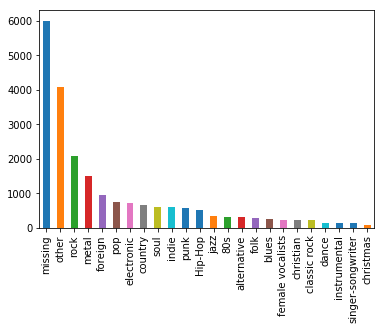

In [24]:
print(df_valid2.tag.value_counts() / np.sum(df_valid2.tag.value_counts()))
df_valid2.tag.value_counts().plot(kind='bar')
plt.show()

### Hacky Genre Featurize
Doing training data only for now...

In [25]:
from sklearn.preprocessing import OneHotEncoder

genre_ohe = OneHotEncoder(sparse=False)
genre_ohe.fit(df_train2[['tag']])

df_train_tfm = genre_ohe.transform(df_train2[['tag']])
df_valid_tfm = genre_ohe.transform(df_valid2[['tag']])

In [26]:
train_audio = AudioDataset(df_train_tfm, train_text)
valid_audio = AudioDataset(df_valid_tfm, valid_text)

In [27]:
multi_data = MultimodalDataLoader(audio_dataset=train_audio,
                                  dataset=train_text)
multi_data_valid = MultimodalDataLoader(audio_dataset=valid_audio,
                                  dataset=valid_text)
multi_db = DataBunch(multi_data, multi_data_valid)

## Model setup

In [28]:
GPU = True
DOWNLOAD_INIT_MODEL = True

In [29]:
## MODEL PARAMS
audio_sz = train_audio.feature_size
vocab_sz = 20002
emb_sz = 400
n_hid = 1150
n_layers = 3
pad_token = 1
qrnn = False
bidir = False
drop_mult = 0.5
dps = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * drop_mult
hidden_p = dps[4]
input_p = dps[0]
embed_p = dps[3]
weight_p = dps[2]
tie_weights = True
output_p = dps[1]
bias = True

In [30]:
multimodal_rnn = MultiModalRNN(audio_sz=audio_sz,
                              vocab_sz=vocab_sz,
                              emb_sz=emb_sz,
                              n_hid=n_hid,
                              n_layers=n_layers,
                              pad_token=pad_token,
                              qrnn=qrnn,
                              bidir=bidir,
                              hidden_p=hidden_p,
                              input_p=input_p,
                              embed_p=embed_p,
                              weight_p=weight_p,
                              output_p=output_p,
                              bias=bias,
                              tie_encoder=tie_weights)

multimodal_rnn

MultiModalRNN(
  (encoder): Embedding(20002, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(20002, 400, padding_idx=1)
  )
  (rnns): None
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
  (multimode): ModuleList(
    (0): WeightDropout(
      (module): LSTM(424, 1150)
    )
    (1): WeightDropout(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDropout(
      (module): LSTM(1150, 400)
    )
  )
  (multidecoder): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=20002, bias=True)
    (output_dp): RNNDropout()
  )
)

In [31]:
learn = RNNLearner(multi_db, multimodal_rnn)

In [32]:
PRETRAINED_TO_MULTI = {
    '0.encoder.weight': 'encoder.weight',
    '0.encoder_dp.emb.weight': 'encoder_dp.emb.weight',
    '0.rnns.0.weight_hh_l0_raw': 'multimode.0.weight_hh_l0_raw',
    '0.rnns.0.module.weight_ih_l0': 'multimode.0.module.weight_ih_l0',
    '0.rnns.0.module.weight_hh_l0': 'multimode.0.module.weight_hh_l0',
    '0.rnns.0.module.bias_ih_l0': 'multimode.0.module.bias_ih_l0',
    '0.rnns.0.module.bias_hh_l0': 'multimode.0.module.bias_hh_l0',
    '0.rnns.1.weight_hh_l0_raw': 'multimode.1.weight_hh_l0_raw',
    '0.rnns.1.module.weight_ih_l0': 'multimode.1.module.weight_ih_l0',
    '0.rnns.1.module.weight_hh_l0': 'multimode.1.module.weight_hh_l0',
    '0.rnns.1.module.bias_ih_l0': 'multimode.1.module.bias_ih_l0',
    '0.rnns.1.module.bias_hh_l0': 'multimode.1.module.bias_hh_l0', 
    '0.rnns.2.weight_hh_l0_raw': 'multimode.2.weight_hh_l0_raw', 
    '0.rnns.2.module.weight_ih_l0': 'multimode.2.module.weight_ih_l0',
    '0.rnns.2.module.weight_hh_l0': 'multimode.2.module.weight_hh_l0',
    '0.rnns.2.module.bias_ih_l0': 'multimode.2.module.bias_ih_l0',
    '0.rnns.2.module.bias_hh_l0': 'multimode.2.module.bias_hh_l0',
    '1.decoder.weight': 'multidecoder.decoder.weight',
    '1.decoder.bias': 'multidecoder.decoder.bias'
}

map_weights(learn,
            INIT_MODEL_PATH/f'models/{init_model_name}_best.pth',
            INIT_MODEL_PATH/f'tmp/itos.pkl',
            PRETRAINED_TO_MULTI,
            pre_rnn=True)

**Create a folder in this model's directory with the name of the initializer model. In that folder, copy a .pth file in the form lstm_<init_model_name>.pth and a .pkl file in the form itos_<init_model_name>.pkl' in order to transfer weights and tokens correctly from the initializer model**

In [36]:
# if MODEL_FIRST_RUN:
#     learn.load_pretrained(MODEL_PATH/f'{init_model_name}/lstm_{init_model_name}.pth', 
#                           MODEL_PATH/f'{init_model_name}/itos_{init_model_name}.pkl')

In [37]:
# def cpu_load(self, name:PathOrStr):
#     """Load model onto CPU that was trained on a GPU `name` from `self.model_dir`.
#        We need these because the fastai load function doesn't allow for a remapping of the storage location."""
#     self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=lambda storage, loc: storage))

# setattr(RNNLearner, 'cpu_load', cpu_load) #monkey patch onto our RNNLearner

In [38]:
# if not MODEL_FIRST_RUN:
#     if not GPU:
#         learn.cpu_load(f'{model_name}_best')
#     else:
#         learn.load(f'{model_name}_best')

## Training

In [33]:
TRAIN = True

In [34]:
@dataclass
class SaveModel(LearnerCallback):
    """Save Latest Model"""
    def __init__(self, learn:Learner, model_name='saved_model'):
        super().__init__(learn)
        self.model_name = model_name
        self.model_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        self.best_loss = None
        self.perplexity = []
        
    def on_epoch_end(self, epoch:int, metrics, last_metrics, **kwargs):
        loss, *_ = last_metrics
        perp = np.exp(loss)
        self.perplexity.append(perp)
        if self.best_loss == None or loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.model_name}_best')
        return False
    
    def on_train_end(self, epoch:int, **kwargs):
        self.learn.save(f'{self.model_name}_last')

In [35]:
save_callback = SaveModel(learn, model_name=f'{model_name}')

In [36]:
# if TRAIN:
#     learn.fit_one_cycle(1, 1e-2)

In [37]:
if TRAIN:
    learn.unfreeze()
    learn.fit(10, 1e-3, callbacks=[save_callback])

Total time: 2:47:14
epoch  train_loss  valid_loss  accuracy
1      2.699656    2.852908    0.466114  (16:47)
2      2.719275    2.855338    0.466129  (16:42)
3      2.698376    2.857357    0.465998  (16:44)
4      2.692522    2.858705    0.465666  (16:44)
5      2.721186    2.859650    0.465718  (16:43)
6      2.730099    2.862320    0.465544  (16:43)
7      2.703019    2.859647    0.465562  (16:42)
8      2.743397    2.862898    0.465465  (16:43)
9      2.738272    2.863207    0.465269  (16:39)
10     2.738727    2.861262    0.465612  (16:42)



In [38]:
print("best validation loss: ", learn.save_model.best_loss)

best validation loss:  2.8529081


In [49]:
## Need to fix model director save
## current just saving to notebook folder and cp manually

In [30]:
#learn.save_encoder(f'{model_name}_encoder')

In [298]:
# x, y = next(iter(learn.data.train_dl))

In [308]:
# x[1]

torch.Size([68, 64, 24])

### Learning Loss

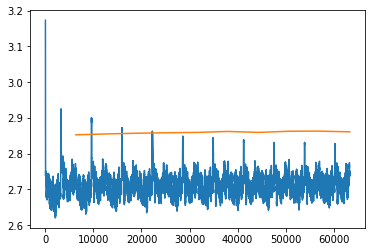

In [39]:
if TRAIN:
    learn.recorder.plot_losses()

### Model Output

In [50]:
if TRAIN:
    MODEL_OUTPUT_NAME = MODEL_PATH/'models'/f'{model_name}_best.pth'
    CLOUD_STORAGE = f'gs://w210-capstone/models/{model_name}_best.pth'

In [51]:
!gsutil cp $MODEL_OUTPUT_NAME $CLOUD_STORAGE

Copying file://../data/models/4.2-MM-108k-pre/models/4.2-MM-108k-pre_best.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/150.9 MiB.                                    


In [52]:
ARCHITECTURE_PATH = MODEL_PATH/'models'/f'{model_name}_architecture.pkl'
ARCHITECTURE_STORAGE = f'gs://w210-capstone/models/{model_name}_architecture.pkl'
ITOS_PATH = INIT_MODEL_PATH/'tmp'/'itos.pkl'
ITOS_STORAGE = f'gs://w210-capstone/models/{model_name}_itos.pkl'

model_dump = learn.model
with open(ARCHITECTURE_PATH, 'wb') as f:
    pickle.dump(model_dump, f)

In [53]:
!gsutil cp $ARCHITECTURE_PATH $ARCHITECTURE_STORAGE

Copying file://../data/models/4.2-MM-108k-pre/models/4.2-MM-108k-pre_architecture.pkl [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/337.8 MiB.                                    


In [54]:
!gsutil cp $ITOS_PATH $ITOS_STORAGE

Copying file://../data/models/4.1-LM-108k-lines/tmp/itos.pkl [Content-Type=application/octet-stream]...
/ [1 files][310.1 KiB/310.1 KiB]                                                
Operation completed over 1 objects/310.1 KiB.                                    


## Text Generation

In [55]:
def generate_step(learner, context, context_length, temp=1):

    model = learner.model
    
    if GPU:
        context = LongTensor(context[-context_length:]).view(-1,1).cuda()
    else:
        context = LongTensor(context[-context_length:]).view(-1,1).cpu()
    
    context = torch.autograd.Variable(context)
    
    model.reset()
    model.eval()

    # forward pass the "context" into the model
    result, *_ = model(context)
    result = result[-1]

    # set unk and pad to 0 prob
    # i.e. never pick unknown or pad
    result[0] = -np.inf
    result[1] = -np.inf

    # softmax and normalize
    probabilities = F.softmax(result/temp, dim=0)
    probabilities = np.asarray(probabilities.detach().cpu(), dtype=np.float)
    probabilities /= np.sum(probabilities) 
    return probabilities

def print_words(context):
    for i in range(len(context)):
        
        step = context[i]

        word = data_lm.valid_ds.vocab.textify([step])

        if word == 'xeol':
            word = '\n'
        elif 'xbol' in word:
            word = word
        elif word == 'xeos': 
            print(word)
            break
            
        print(word, end=' ')   

def generate_text(learner, seed_text=['xbos'], max_len=500, GPU=False, context_length=20, beam_width=5, verbose=True, temp=1):
    """Generates text with a given learner and returns best options.

    Parameters
    ----------
    learner : RNNLearner Language Model (RNNLearner.language_model())
        Fastai RNNLearner with tokenized language model data already loaded 
        
    seed_text : list or str
        List of strings where each item is a token. (e.g. ['the', 'cat']) or string that is split on white space

    max_len : int
        Number of words in generated sequence
        
    gpu : bool
        If you're using a GPU or not...
    
    context_length : int
        Amount of words that get input as "context" into the model. Set to 0 for no limit   
        
    beam_width : int
        How many new word indices to try out...computationally expensive
    
    verbose : bool
        If True, prints every possible context for a given word cycle

    temperature : float
        Scales the logits before softmax. A higher temp (>1) increases variety whereas a low temp (<=1) will often result in a loop

    Returns
    -------
    context_and_scores : list of lists
        Returns a sorted list of the entire tree search of contexts and their respective scores in the form:
        [[context, score], [context, score], ..., [context, score]]
    """
        
    if isinstance(seed_text, str):
        seed_text = data_lm.train_ds.vocab.numericalize(seed_text.split(' '))
    
    
    # Width for the beam search, to be externalized along with general decoding
    beam_width = beam_width
    
    # List of candidate word sequence. We'll maintain #beam_width top sequences here.
    # The context is a list of words, the scores are the sum of the log probabilities of each word
    context_and_scores = [[seed_text, 0.0]]
    
    # Loop over max number of words
    for word_number in range(max_len):
        if verbose: print(f'Generating word: {word_number+1} / {max_len}')

        candidates = []
        
        # For each possible context that we've generated so far, generate new probabilities, 
        # and pick an additional #beam_width next candidates
        for i in range(len(context_and_scores)):
            # Get a new sequence of word indices and log-probability
            # Example: [[2, 138, 661], 23.181717]
            context, score = context_and_scores[i]
            
            # Obtain probabilities for next word given the context 
            probabilities = generate_step(learner, context, context_length, temp)

            # Multinomial draw from the probabilities
            multinom_draw = np.random.multinomial(beam_width, probabilities)
            top_probabilities = np.argwhere(multinom_draw != 0).flatten()
                        
            #For each possible new candidate, update the context and scores
            for j in range(len(top_probabilities)):
                next_word_idx = top_probabilities[j]
                new_context = context + [next_word_idx]
                candidate = [new_context, (score - np.log(probabilities[next_word_idx]))]
                candidates.append(candidate)
        
        #update the running tally of context and scores and sort by probability of each entry
        context_and_scores = candidates
        context_and_scores = sorted(context_and_scores, key = lambda x: x[1]) #sort by top entries
#         np.random.shuffle(context_and_scores)

        context_and_scores = context_and_scores[:15] #for now, only keep the top 15 to speed things up but we can/should change this to beam_width or something else
        
        if verbose:
            for context, score in context_and_scores:
                print_words(context)
                print('\n')
    
    return context_and_scores
    

In [43]:
final_scores = generate_text(learn, GPU=GPU, seed_text='xbos xbol-1 i loved him more', max_len=200, context_length=40, beam_width=3, verbose=False, temp=1.5)

In [44]:
#print all of the final options of songs
for song, score in final_scores:
    print_words(song)
    print(score)
    print('\n')

xbos xbol-1 i loved him more all the time 
 xbol-2 who thought it would last for all of our life ? 
 xbol-3 
 xbol-4 does it mean that it can 't stand wrong ? 
 xbol-5 does it mean that it 's wrong for us 
 xbol-6 was it wrong for us to be alone ? 
 xbol-7 
 xbol-8 will you find a way ! 
 xbol-9 yeah , yeah ! 
 xbol-10 
 xbol-11 oh where you gonna run ? 
 xbol-12 don 't stand in my way 
 xbol-13 i 'm gonna take you all the way 
 xbol-14 yeah around and around 
 xbol-15 'cause i 'll take you home 
 xbol-16 i 'm gonna take you home 
 xbol-17 i 'm gonna wait tonight 
 xbol-18 i 'm gonna take you home tonight 
 xbol-19 i 'm gonna break you down 
 xbol-20 wanna take you home tonight 
 xbol-21 i 'm gonna sit right here 
 xbol-22 i 'm gonna take you out tonight 
 xbol-23 scream and shout 
 xbol-24 all night long 
 xbol-25 
 xbol-26 dozen miles 
 xbol-27 tell all of your friends 
 xbol-28 tell all of your friends 
 xbol-29 through all 461.6566628700193


xbos xbol-1 i loved him more all the ti